In [210]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.typing import NDArray
from scipy import stats
import scipy

In [211]:
transition_matrix = np.array([
    [-0.0085, 0.005,  0.0025, 0.0,    0.001],
    [0.0,    -0.014,  0.005,  0.004,  0.005],
    [0.0,     0.0,   -0.008,  0.003,  0.005],
    [0.0,     0.0,    0.0,   -0.009,  0.009],
    [0.0,     0.0,    0.0,    0.0,    0.0  ]
])

## Task 7

In [212]:
class Simulation:
    def __init__(self, transition_matrix) -> None:
        self.transition_matrix = transition_matrix

    def simulate_time(self, rate) -> float:
        return np.random.exponential(scale=1/rate)
    
    def simulate_transition(self, state) -> int:
        probs = np.copy(self.transition_matrix[state])
        probs[state] = 0
        probs /= sum(probs)
        next_state = np.random.choice([i for i in range(len(probs))], p=probs)
        return next_state
    
    def simulate_one(self) -> tuple[list, list, bool]:
        states = [0]
        times = []
        reappeared = False
        while True:
            state = states[-1]
            times.append(self.simulate_time(-self.transition_matrix[state][state]))
            next_state = self.simulate_transition(state)
            if next_state == self.transition_matrix.shape[0] - 1:
                break
            if next_state in (2, 3) and sum(times) > 30.5:
                reappeared = True
            states.append(next_state)
        return states, times, reappeared
    
    def simulate(self, num_simulations: int) -> tuple[NDArray, float]:
        arr = np.empty(num_simulations)
        reappeared_counter = 0
        for i in range(num_simulations):
            states, times, reappeared = self.simulate_one()
            arr[i] = np.sum(times)
            if reappeared:
                reappeared_counter += 1
        self.times = arr
        return arr, reappeared_counter / num_simulations
    
    def Ft(self, t):
        Qs = self.transition_matrix[:-1, :-1]
        p0 = np.zeros(Qs.shape[0])
        p0[0] = 1
        return 1 - p0 @ scipy.linalg.expm(Qs * t) @ np.ones(Qs.shape[0])
    
    def evaluate(self):
        points = np.array([[t, self.Ft(t)] for t in np.linspace(0, 1200, 10_000)])

        n = len(self.times)
        x = np.sort(self.times)
        y = np.arange(1, n+1) / n

        plt.plot(points[:, 0], points[:, 1])
        plt.plot(x, y, marker='.', linestyle='none')
        plt.xlabel('Time (months)')
        plt.ylabel('Cumulative Probability')
        plt.title('Empirical Cumulative Distribution Function of Time to Death')
        plt.grid(True)
        plt.legend(["Theoretical data", "Simulated data"])
        plt.show()

    def plot_survival(self):
        t_values = np.array([t for t in np.linspace(0, 1200, 10_000)])
        N = len(self.times)
        d_t = lambda t: sum(self.times <= t)
        S_t = lambda t: (N - d_t(t)) / N
        survival_func_points = [S_t(t) for t in t_values]
        plt.plot(t_values, survival_func_points)

In [213]:
sim = Simulation(transition_matrix)
N = 1000
times, reappeared_rate = sim.simulate(N)

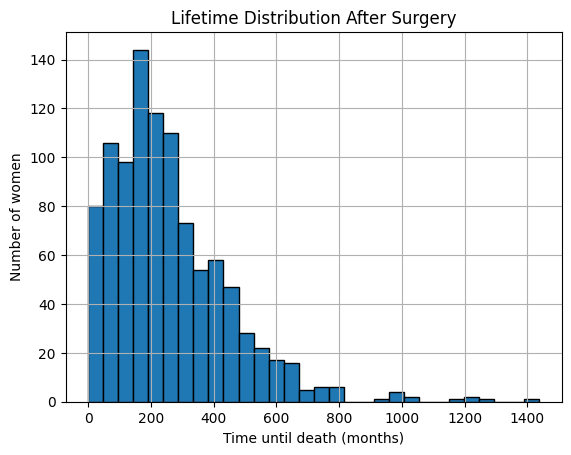

Mean lifetime: 259.73 months
95% CI for mean: (247.94, 271.51)
Standard deviation: 189.95 months
95% CI for std: (181.98, 198.67)


In [214]:
# 1. Histogram of lifetime
plt.hist(times, bins=30, edgecolor='black')
plt.title('Lifetime Distribution After Surgery')
plt.xlabel('Time until death (months)')
plt.ylabel('Number of women')
plt.grid(True)
plt.show()

# 2. Stats
mean_time = np.mean(times)
std_time = np.std(times, ddof=1)  # sample std

# 95% Confidence Interval for the mean
n = len(times)
conf_int_mean = stats.t.interval(0.95, df=n-1, loc=mean_time, scale=stats.sem(times))

# 95% Confidence Interval for the std using Chi-square
alpha = 0.05
chi2_lower = stats.chi2.ppf(1 - alpha/2, df=n-1)
chi2_upper = stats.chi2.ppf(alpha/2, df=n-1)
conf_int_std = (
    np.sqrt((n - 1) * std_time**2 / chi2_lower),
    np.sqrt((n - 1) * std_time**2 / chi2_upper)
)

print(f"Mean lifetime: {mean_time:.2f} months")
print(f"95% CI for mean: ({conf_int_mean[0]:.2f}, {conf_int_mean[1]:.2f})")
print(f"Standard deviation: {std_time:.2f} months")
print(f"95% CI for std: ({conf_int_std[0]:.2f}, {conf_int_std[1]:.2f})")

In [215]:
print(f"Proportion of women with reappearing distantly after 30.5 months: {reappeared_rate:.3f}")

Proportion of women with reappearing distantly after 30.5 months: 0.630


## Task 8

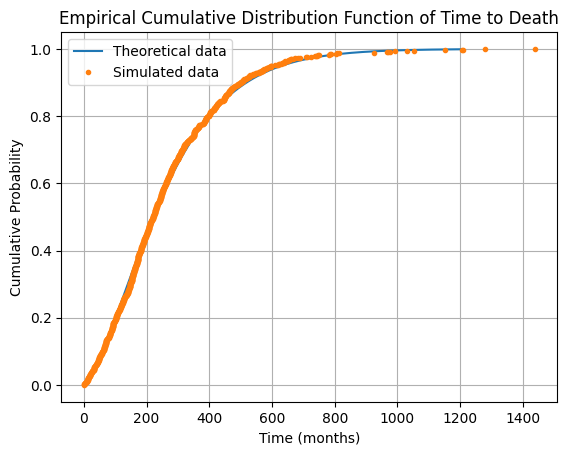

In [216]:
sim.evaluate()

In [221]:
from scipy.stats import kstest
stat, p_value = kstest(sim.times, np.vectorize(sim.Ft))
print(f"p-value for ks-test: {p_value:.3f}")

p-value for ks-test: 0.435


## Task 9

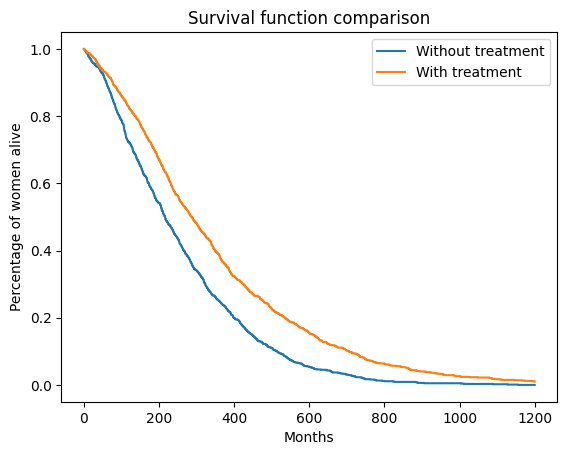

In [ ]:
Q = np.array([
    [-0.00475, 0.0025, 0.00125, 0.0,    0.001],
    [0.0,     -0.007,  0.0,     0.002,  0.005],
    [0.0,      0.0,   -0.008,   0.003,  0.005],
    [0.0,      0.0,    0.0,    -0.009,  0.009],
    [0.0,      0.0,    0.0,     0.0,    0.0]
])
sim2 = Simulation(Q)
times2, reappeared_rate2 = sim2.simulate(1000)

fig, ax = plt.subplots(1, 1)
sim.plot_survival()
sim2.plot_survival()
plt.legend(["Without treatment", "With treatment"])
plt.title("Survival function comparison")
plt.xlabel("Months")
plt.ylabel("Percentage of women alive")
plt.show()

Treatment appears to help by prolonging life expentancy.